<h1 style='color: green; font-size: 26px; font-weight: bold;'> 3. Previsão de falha <h1>

### Notebook 2
1.  Pré Processamento II
2. Feature engineering
3. Modelagem
4. Avaliação
5. Modelo final
6. Avaliação do modelo e custo
6. Conclusão.

<strong>Descripción</strong>
<p>Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
diariamente telemetría agregada en varios atributos.
Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
</p>

<strong>Entregable</strong>
<p>Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9
atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
el valor binario 0 para no fallar y 1 para fallar
</p>

# Carregando os dados

In [193]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [194]:
dir_data = "F:\PycharmProjects\DesaioMELI\data"
df = pd.read_csv(dir_data+r'\full_devices.csv', sep=',', encoding='ISO-8859-1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


coluna 'failure'
1 = Equipamento falhou
0 = Equipamento não falhou

'device'
equipamento monitorado

'attribute1'
pode ser algum código, não tenho certeza.


In [195]:
df.nunique()

date             304
device          1169
failure            2
attribute1    123877
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

In [196]:
df.groupby(['device']).agg(['count']).shape

(1169, 11)

In [197]:
df.groupby(['date']).agg(['count']).shape

(304, 11)

In [198]:
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

# Pré processamento II

In [199]:
#Tranformando os tipos de dados
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [200]:
ini_date = pd.to_datetime(df['date'][0])
end_date = ini_date + pd.Timedelta(days=163)
df = df[df.date <= end_date]
df.failure.value_counts()

0    92179
1       79
Name: failure, dtype: int64

In [201]:
# Eliminando o registro duplicado identificado no notebook 1
df = df.drop_duplicates()

In [202]:
df.shape

(92258, 12)

In [203]:
df.groupby(['failure'])['device'].count()

failure
0    92179
1       79
Name: device, dtype: int64

In [204]:
#percentual de falha em 11 meses
print('Percentual de falha: {:.5f}%'.format(df.groupby(['failure'])['device'].count().iloc[1] / df['device'].count()))

Percentual de falha: 0.00086%


In [205]:
#ordenando o dataset por data e pelo device para posteriormente verificar o histórico até a falha
df = df.sort_values(by=['device','date'], ascending=[True, True])
df['flipper'] = np.where((df.device != df.device.shift(1)), 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1
1163,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0
2326,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0
3489,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0
4651,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0


<strong>Pensando no oversampling, somente duplicar os dados pode gerar overfitting, pois existe um tempo de vida para cada dispositivo e um período de uso para falha, visto que não é um evento comum, então introduzir somente os registros de falhas, sem considerar os dados que antecem o evento resultará em um viés que acarretará em overfitting. O viés é inevitavél, mas o ideal é que acompanhe o comportamento dos dados.</strong>

Dito isso, vou criar algumas features para obter essa informação de comportamento dos dados até a falha e com isso gerar os novos registros, além de tranformar os dados de colunas para melhor se adequarem a modelagem.

In [206]:
#pega o 1º registro para cada dispositivo, com a coluna criada 'flipper'
starter = df[df['flipper'] == 1]
starter = starter[['date','device']]
starter = starter.rename(index=str, columns={"date": "start_date"})
starter['start_date'] = pd.to_datetime(starter['start_date'])

In [207]:
#Merge start_date com o dataset original, para marcar a data de inicio de monitoramento de cada dispositivo
df = df.sort_values(by=['device', 'date'], ascending=[True, True])
starter = starter.sort_values(by=['device'], ascending=[True])
df = df.merge(starter, on=['device'], how='left')

In [208]:
df[df['failure'] == 1].groupby(['date','start_date'])['device'].count()

date        start_date
2015-01-05  2015-01-01    1
2015-01-07  2015-01-01    1
2015-01-09  2015-01-01    1
2015-01-13  2015-01-01    1
2015-01-14  2015-01-01    1
2015-01-17  2015-01-01    1
2015-01-18  2015-01-01    1
2015-01-19  2015-01-01    8
2015-01-20  2015-01-01    1
2015-01-22  2015-01-01    1
2015-01-23  2015-01-01    2
2015-01-26  2015-01-01    1
2015-01-27  2015-01-01    1
2015-01-28  2015-01-01    1
2015-01-29  2015-01-01    2
2015-02-02  2015-01-01    2
2015-02-04  2015-01-01    3
2015-02-05  2015-01-01    1
2015-02-09  2015-01-01    2
2015-02-14  2015-01-01    1
2015-02-18  2015-01-01    1
2015-02-19  2015-01-01    1
2015-02-21  2015-01-01    1
2015-02-23  2015-01-01    1
2015-02-27  2015-01-01    1
2015-03-04  2015-01-01    1
2015-03-05  2015-01-01    1
2015-03-17  2015-01-01    2
2015-03-19  2015-01-01    2
2015-03-24  2015-01-01    2
2015-03-25  2015-01-01    1
2015-04-03  2015-01-01    1
2015-04-06  2015-01-01    1
2015-04-09  2015-01-01    1
2015-04-17  2015-01-01   

In [209]:
# Calcula os dias até a falha para cada dispositivo, contando a partir do momento que se iniciou a monitoria do dispositivo
#Isso irá servir para encontrar o valor do ciclo para usar como janela no agrupamento
devices = df['device'].unique()
failure_record = []
no_failured = []
for device in devices:
    start_date = df.loc[(df['device'] == device) & (df['flipper'] == 1), 'date'].iloc[0]
    falhas_dispositivo = df.loc[(df['device'] == device) & (df['failure'] == 1), 'date']
    if not falhas_dispositivo.empty:
        data_falha = falhas_dispositivo.min()
        dias_decorridos = (data_falha - start_date).days
        failure_record.append({
            'device': device,
            'count_days': dias_decorridos,
            'start_date': start_date,
            'failure_date': data_falha.date()
        })
    else:
        no_failured.append({
            'device': device,
            'start_date': start_date,
        })

In [210]:
#Dataframe com os dispositivos que falharam e outro com os que não falharam
df_failured_record = pd.DataFrame(failure_record).sort_values(by='failure_date').reset_index(drop=True)
df_non_failured_record = pd.DataFrame(no_failured).sort_values(by='start_date').reset_index(drop=True)

In [211]:
df_non_failured_record

,device,start_date
0,S1F01085,2015-01-01
1,W1F0X5TL,2015-01-01
2,W1F0X5VA,2015-01-01
3,W1F0X60T,2015-01-01
4,W1F0X6CF,2015-01-01
...,...,...
1085,S1F02W1L,2015-05-06
1086,S1F02XLX,2015-05-06
1087,S1F013BB,2015-05-06
1088,S1F03499,2015-05-06


In [212]:
df_failured_record

,device,count_days,start_date,failure_date
0,S1F0RRB1,4,2015-01-01,2015-01-05
1,S1F0CTDN,6,2015-01-01,2015-01-07
2,W1F0PNA5,8,2015-01-01,2015-01-09
3,W1F13SRV,12,2015-01-01,2015-01-13
4,W1F1230J,13,2015-01-01,2015-01-14
...,...,...,...,...
74,W1F0WBTM,140,2015-01-01,2015-05-21
75,S1F0QF3R,147,2015-01-01,2015-05-28
76,S1F0GSD9,147,2015-01-01,2015-05-28
77,W1F0Z3KR,160,2015-01-01,2015-06-10


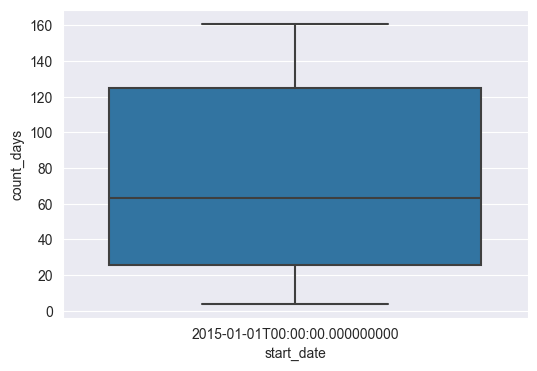

In [213]:
plt.figure(figsize=(6,4))
sns.boxplot(x= 'start_date',y='count_days',data=df_failured_record)
plt.show()

array([[<Axes: title={'center': 'count_days'}>,
        <Axes: title={'center': 'start_date'}>]], dtype=object)

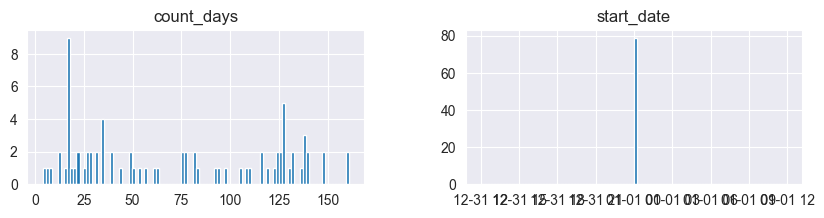

In [214]:
#Distribuição dos dispositivos que falharam em dias corrido a partir do inicio da monitoria de cada um
ax = df_failured_record.hist(bins=100, figsize=(10,2))
ax

In [215]:
df_failured_record.describe()

,count_days
count,79.000000
mean,72.911392
std,49.369406
min,4.000000
25%,25.500000
50%,63.000000
75%,125.000000
max,161.000000


In [216]:
#mediana
df_failured_record.mode()

,device,count_days,start_date,failure_date
0,S1F023H2,18.0,2015-01-01,2015-01-19
1,S1F0CTDN,NaN,NaT,NaN
2,S1F0DSTY,NaN,NaT,NaN
3,S1F0F4EB,NaN,NaT,NaN
4,S1F0GG8X,NaN,NaT,NaN
...,...,...,...,...
74,Z1F1653X,NaN,NaT,NaN
75,Z1F1901P,NaN,NaT,NaN
76,Z1F1AG5N,NaN,NaT,NaN
77,Z1F1FCH5,NaN,NaT,NaN


In [217]:
#Falhas ranqueada por data
df_failured_record.groupby('failure_date')['device'].count().sort_values(ascending=False)

failure_date
2015-01-19    8
2015-02-04    3
2015-05-08    3
2015-03-17    2
2015-05-09    2
2015-03-24    2
2015-03-19    2
2015-05-05    2
2015-02-09    2
2015-05-07    2
2015-01-29    2
2015-02-02    2
2015-05-13    2
2015-05-28    2
2015-05-20    2
2015-05-21    2
2015-01-23    2
2015-05-12    1
2015-04-21    1
2015-06-10    1
2015-04-09    1
2015-04-17    1
2015-04-20    1
2015-04-30    1
2015-04-27    1
2015-04-28    1
2015-05-04    1
2015-05-19    1
2015-05-18    1
2015-04-03    1
2015-04-06    1
2015-01-05    1
2015-03-25    1
2015-01-07    1
2015-01-09    1
2015-01-13    1
2015-01-14    1
2015-01-17    1
2015-01-18    1
2015-01-20    1
2015-01-22    1
2015-01-26    1
2015-01-27    1
2015-01-28    1
2015-02-05    1
2015-02-14    1
2015-02-18    1
2015-02-19    1
2015-02-21    1
2015-02-23    1
2015-02-27    1
2015-03-04    1
2015-03-05    1
2015-06-11    1
Name: device, dtype: int64

Todos os dispositivos que falharam são monitorados desde o dia 01-01 e 75% deles falharam em até 163 dias após essa data.
O dia que mais dispositivos falharam aconteceu 18 dias após a data de inicio da monitoria, no total foram 8 dispositivos.
Vou utilizar essa janela de dias para fazer a Sobreamostragem e agregação dos dados dos sensores.

# Feature engineering

### Novas colunas auxiliares

In [218]:
#Esta é a janela pela qual será feita a agregação dos valores das colunas.
window = 18

In [219]:
#pegando o primeiro registro para cada máqui, com a coluna flipper
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01


In [220]:
#Calcula o número de dias corridos para cada dispositivo até atingir 'window',
df['count_days'] = df['date'] - df['start_date']
df['time_since_start'] = df['count_days'] / np.timedelta64(1, 'D')
df = df.drop(columns=['count_days'])
# quando valor for 1, o histórico de monitoramento do dispositivo tem menos que 18 dias
df['too_soon'] = np.where((df.time_since_start < window) , 1, 0)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,0,2015-01-01,4.0,1


In [221]:
#Drop da coluna attribute8 por ter correlação perfeita positiva com a attribute9
df.drop('attribute8', axis=1, inplace=True)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,start_date,time_since_start,too_soon
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,1,2015-01-01,0.0,1
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,0,2015-01-01,1.0,1
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,0,2015-01-01,2.0,1
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,0,2015-01-01,3.0,1
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,0,2015-01-01,4.0,1


### Oversamplig - gerando mais casos de falha para balanceamento das classes

No primeiro momento vou testar a janela encontrada com a moda da coluna de datas para falhas.
A técnica será a de SMOTE (Synthetic Minority Over-sampling Technique), ela gera amostras sintéticas da classe minoritária. Para cada exemplo da classe minoritária é selecionado aleatóriamente um valor k vizinhos mais próximos para criar novos exemplos. Usarei a janela (18) para K e a quantidade de amostras ((taxa de oversampling) será determinada pela razão: (tamanho_nao_falhas / tamanho_falhas) - 1) / 10.

In [222]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


#trasformação da coluna de dispositivos
encoder = LabelEncoder()

df['device_encoder'] = encoder.fit_transform(df['device'])
print('Quantidade de device: {} e device Encoder: {}'.format(df['device'].nunique(), df['device_encoder'].nunique()))
df.drop('device', axis=1, inplace=True)

#colunas de datas precisam ser convertidas
df["date"] = (pd.to_datetime(df["date"]) - datetime(1970, 1, 1)).dt.total_seconds()
df["start_date"] = (pd.to_datetime(df["start_date"]) - datetime(1970, 1, 1)).dt.total_seconds()

Quantidade de device: 1169 e device Encoder: 1169


In [223]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def oversamplit_SMOTE(data, tx):
    # Separando as features e o target
    X = data.drop('failure', axis=1)
    y = data['failure']

    # Verifique a contagem de classe antes do oversampling
    print('Contagem de classe antes do oversampling:', Counter(y))

    # Determine a taxa de oversampling
    minority_class_size = len(data[data['failure'] == 1])
    majority_class_size = len(data[data['failure'] == 0])
    oversampling_rate = (1 - (minority_class_size / majority_class_size)) * tx

    # Use SMOTE para gerar amostras sintéticas com a taxa de oversampling
    smote = SMOTE(sampling_strategy=oversampling_rate, k_neighbors=18, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Verifique a contagem de classe depois do oversampling
    print('Contagem de classe depois do oversampling:', Counter(y_resampled))
    print(y_resampled.mean())
    # Criando um novo DataFrame com as features resampleadas e o target resampleado
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled['failure'] = y_resampled
    return df_resampled

df_resampled = oversamplit_SMOTE(df, 0.03)

Contagem de classe antes do oversampling: Counter({0: 92179, 1: 79})
Contagem de classe depois do oversampling: Counter({0: 92179, 1: 2763})
0.029101978049756692


O percentual de falha original é: 0.83%. Ainda está muito desbalanceado, por enquanto irei manter essas quantidades, para não introduzir um viés alto antes de fazer o split entre treino e teste. Depois desse split, vou fazer o SMOTE de novo para gerar noso registros no dataset de treino.

In [224]:
df_resampled.shape

(94942, 15)

<Axes: xlabel='failure', ylabel='count'>

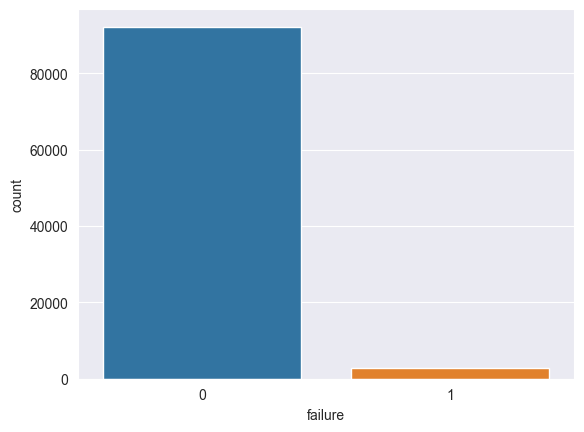

In [225]:
sns.countplot(data=df_resampled, x='failure')

In [226]:
#ordenando novamente pelo device e date
df_resampled.sort_values(by=['device_encoder','date'], ascending=[True, True]).head(30)

,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,start_date,time_since_start,too_soon,device_encoder,failure
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,1.420070e+09,0.0,1,0,0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,1.420070e+09,1.0,1,0,0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,1.420070e+09,2.0,1,0,0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,1.420070e+09,3.0,1,0,0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,1.420070e+09,4.0,1,0,0
5,1.420502e+09,128832128,56,0,52,6,409404,0,7,0,1.420070e+09,5.0,1,0,0
6,1.430870e+09,14533968,0,0,0,5,688952,0,0,1,1.430870e+09,0.0,1,1,0
7,1.430957e+09,46202296,0,0,0,5,688952,0,0,0,1.430870e+09,1.0,1,1,0
8,1.431043e+09,214383720,0,0,0,5,688964,0,0,0,1.430870e+09,2.0,1,1,0
9,1.431130e+09,243346080,0,0,0,5,689035,0,0,0,1.430870e+09,3.0,1,1,0


### Tranformação dos dados

Os dados são bem dispersos, então para a transformação vou utilizar a média, mediana, o máximo e o minímo das colunas de telemetria.

In [227]:
def tranform_new_data(colum):
    df_resampled[colum+'_mean'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).mean()), df_resampled[colum])
    df_resampled[colum+'_median'] =np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1,window=window).median()), df_resampled[colum])
    df_resampled[colum+'_max'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).max()), df_resampled[colum])
    df_resampled[colum+'_min'] = np.where((df_resampled.too_soon == 0),(df_resampled[colum].rolling(min_periods=1, window=window).min()), df_resampled[colum])

#Colunas para transformação
for i in df_resampled.columns[1:9]:
    tranform_new_data(df_resampled[i].name)

In [228]:
df_resampled.head()

,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,...,attribute6_max,attribute6_min,attribute7_mean,attribute7_median,attribute7_max,attribute7_min,attribute9_mean,attribute9_median,attribute9_max,attribute9_min
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,...,407439.0,407439.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,...,408114.0,408114.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0


In [229]:
df_resampled.head(10)


,date,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,flipper,...,attribute6_max,attribute6_min,attribute7_mean,attribute7_median,attribute7_max,attribute7_min,attribute9_mean,attribute9_median,attribute9_max,attribute9_min
0,1.420070e+09,215630672,56,0,52,6,407438,0,7,1,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
1,1.420157e+09,1650864,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
2,1.420243e+09,124017368,56,0,52,6,407438,0,7,0,...,407438.0,407438.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
3,1.420330e+09,128073224,56,0,52,6,407439,0,7,0,...,407439.0,407439.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
4,1.420416e+09,97393448,56,0,52,6,408114,0,7,0,...,408114.0,408114.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
5,1.420502e+09,128832128,56,0,52,6,409404,0,7,0,...,409404.0,409404.0,0.0,0.0,0.0,0.0,7.0,7.0,7.0,7.0
6,1.430870e+09,14533968,0,0,0,5,688952,0,0,1,...,688952.0,688952.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.430957e+09,46202296,0,0,0,5,688952,0,0,0,...,688952.0,688952.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.431043e+09,214383720,0,0,0,5,688964,0,0,0,...,688964.0,688964.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.431130e+09,243346080,0,0,0,5,689035,0,0,0,...,689035.0,689035.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
df = df_resampled

### Separação dos dados entre treino e teste por estratificação

In [231]:
from sklearn.model_selection import train_test_split
# Separando as features e o target
X = df.drop('failure', axis=1)
y = df['failure']
stratify_col = df['device_encoder']

# dividindo o conjunto de dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify_col, test_size=0.15, random_state=45)

# Verificando as proporções das classes nos conjuntos de treino e teste
print('Proporção de classe no conjunto de treino:', y_train.value_counts(normalize=True))
print('Proporção de classe no conjunto de teste:', y_test.value_counts(normalize=True))

# Exibindo a quantidade de registros em cada conjunto de dados
print('\nNúmero de registros no conjunto de treino:', len(X_train))
print('Número de registros no conjunto de teste:', len(X_test))

# Exibindo a contagem de valores únicos na coluna 'failure' para cada conjunto de dados
print('\nContagem de valores failure no conjunto de treino:')
print(y_train.value_counts())

print('\nContagem de valores failure no conjunto de teste:')
print(y_test.value_counts())

Proporção de classe no conjunto de treino: 0    0.970929
1    0.029071
Name: failure, dtype: float64
Proporção de classe no conjunto de teste: 0    0.97072
1    0.02928
Name: failure, dtype: float64

Número de registros no conjunto de treino: 80700
Número de registros no conjunto de teste: 14242

Contagem de valores failure no conjunto de treino:
0    78354
1     2346
Name: failure, dtype: int64

Contagem de valores failure no conjunto de teste:
0    13825
1      417
Name: failure, dtype: int64


In [232]:
#Tranformando novamente as colunas de data
# df_resampled['date'] = pd.to_datetime(df_resampled['date'],unit='s')
# df_resampled['start_date'] = pd.to_datetime(df_resampled['start_date'],unit='s')
#
# df_resampled['start_date'] = df_resampled['start_date'].dt.strftime('%Y-%m-%d')
# df_resampled['date'] = df_resampled['date'].dt.strftime('%Y-%m-%d')

### Oversampling mais intenso com SMOTE nos dados de treino

In [233]:
# Concatenando as features e o target
train_df = pd.concat([X_train, y_train], axis=1)
# Chamando a função de Oversampling, agora permitindo uma taxa maior
train_df = oversamplit_SMOTE(train_df, 1)

Contagem de classe antes do oversampling: Counter({0: 78354, 1: 2346})
Contagem de classe depois do oversampling: Counter({0: 78354, 1: 76008})
0.4924009795156839


In [234]:
df.failure.value_counts()

0    92179
1     2763
Name: failure, dtype: int64

agora irei trabalhar com esse novo dataset para treinamento dos modelos - train_df

##### Inicialmente, irei utilizar todas colunas para avaliação de Feaute importance.

In [235]:
# Separando as features e o target
X2 = df.drop('failure', axis=1)
y2 = df['failure']
stratify_col2 = df['device_encoder']

# dividindo o conjunto de dados em treino e teste com estratificação
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=stratify_col2, test_size=0.20, random_state=45)

# Exibindo a contagem de valores únicos na coluna 'failure' para cada conjunto de dados
print('\nContagem de valores failure no conjunto de treino:')
print(y_train2.value_counts())

print('\nContagem de valores failure no conjunto de teste:')
print(y_test2.value_counts())


Contagem de valores failure no conjunto de treino:
0    73726
1     2227
Name: failure, dtype: int64

Contagem de valores failure no conjunto de teste:
0    18453
1      536
Name: failure, dtype: int64


# Modelagem

In [236]:
#imports das bibliotecas para treinar os modelos
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, roc_auc_score

In [237]:
# Função para chamar o pipeline de predição e gerar a confusion matrix
def prediction_pipe(clf):
  clf.fit(X_train2, y_train2)
  y_pred = clf.predict(X_test2)
  cm = confusion_matrix(y_test2, y_pred, labels=clf.classes_, normalize='all')
  print('F1 Score:', f1_score(y_test2, y_pred))
  print('Matriz de confusão: \n', cm, '\n')
  print("===============================================")

In [238]:

# Aplicando pipelines de modelos para diferentes classificadores
pipeline_lr = Pipeline([('lr_classifier',LogisticRegression())])
# pipeline_svm = Pipeline([('svm_classifier',SVC())])
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier())])
pipeline_gbcl = Pipeline([('gbcl_classifier',GradientBoostingClassifier())])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
pipeline_knn = Pipeline([('knn_classifier',KNeighborsClassifier())])


# Aplicando modelos

pipelines = {'Logistic Regression':pipeline_lr, 'Decision Tree':pipeline_dt, 'Gradient Boosting':pipeline_gbcl, 'Random Forest':pipeline_rf, 'KNeighbors':pipeline_knn }
for k, pipe in pipelines.items():
  print(k)
  prediction_pipe(pipe)

Logistic Regression


F:\PycharmProjects\DesaioMELI\meli\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 Score: 0.0
Matriz de confusão: 
 [[9.71667808e-01 1.05324135e-04]
 [2.82268682e-02 0.00000000e+00]] 

Decision Tree
F1 Score: 0.9721189591078068
Matriz de confusão: 
 [[9.70877877e-01 8.95255148e-04]
 [6.84606878e-04 2.75422613e-02]] 

Gradient Boosting
F1 Score: 0.9812382739212007
Matriz de confusão: 
 [[9.71404497e-01 3.68634473e-04]
 [6.84606878e-04 2.75422613e-02]] 

Random Forest
F1 Score: 0.9840075258701788
Matriz de confusão: 
 [[9.71562484e-01 2.10648270e-04]
 [6.84606878e-04 2.75422613e-02]] 

KNeighbors
F1 Score: 0.16842105263157894
Matriz de confusão: 
 [[0.9679288  0.00384433]
 [0.02527779 0.00294908]] 



Random Forest se mostrou o algoritmo com melhor desempenho, vou seguir com ele para fazer o ajuste de hiperparametro e avaliação do modelo.

In [239]:

# Aplicando o Random Forest
params = {
    'n_estimators': 75,
     'min_samples_split': 10,
     'min_samples_leaf': 2,
     'max_features': 'sqrt',
     'max_depth': 3,
     'bootstrap': True}

clf = RandomForestClassifier(**params)
clf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)

In [240]:
#Agora o teste com o outro dataset de teste que separei no primeiro Oversampling
print(classification_report(y_test2, clf.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18453
           1       1.00      0.96      0.98       536

    accuracy                           1.00     18989
   macro avg       1.00      0.98      0.99     18989
weighted avg       1.00      1.00      1.00     18989



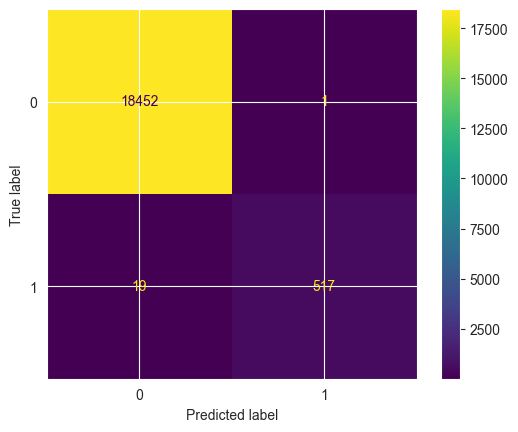

In [241]:
# Matriz de confusão
cm = confusion_matrix(y_test2, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

A previsão para não falha está boa, como era de se esperar pela quantidade de dados dessa classe.
O percentual de TP está dentro da proporção esperada, mas ainda há uma melhoria a ser feita, visto que o custo para uma manutenção preventiva é a metade do custo para manutenção quando o equipamento quebra, uma quantidade maior de Falso positivo (até um certo limite) geraria um custo menor comparado com Falso Negativo, ou seja, se o modelo prever que um equipamento irá falhar e acarretar manutenção, sem estar quebrado, é melhor do que prever que o equipamento não irá falhar e ele falhar, de acordo com os custos infomados na descrição do problema.
Então, o FN pode na verdade tornar o modelo nada eficiente. Nos próximos passos irei fazer a análise das features e alterar o peso de cada target, se melhorar essa questão, manterei o modelo, caso contrário, partirei para a abordagem de aprendizado Semi-supervisionado, antes de fazer a modelagem por mês.
Essa abordagem mensal exigiria reprocessamento do Oversampling para se adequar a janela.

Segundo o enunciado: a falha do equipamento tem custo 1 e a manutenção preventiva tem custo 0.5.
Vou usar isso como peso no treinamento e na avaliação (se por exemplo, para X equipamentos monitorados, qual o custo gerado de acordo com a previsão do modelo e resultado da confusion matrix).

#### Seguindo com a análise de feature importance

In [242]:
# Prever as probabilidades da classe positiva (1) para os dados de teste
clf.predict_proba(X_test2)

array([[9.98973640e-01, 1.02636018e-03],
       [9.99185554e-01, 8.14446018e-04],
       [9.98152945e-01, 1.84705460e-03],
       ...,
       [9.98154888e-01, 1.84511242e-03],
       [9.99070778e-01, 9.29222256e-04],
       [9.98906307e-01, 1.09369269e-03]])

In [243]:
# Prever as probabilidades da classe positiva (1) para os dados de teste
y_pred_prob = clf.predict_proba(X_test2)[:,1]
fpr, tpr, thresholds = roc_curve(y_test2, y_pred)
print('TPR: ', tpr.mean())
print('FPR: ',fpr.mean())
print('thresholds', thresholds.mean())

TPR:  0.6548507462686567
FPR:  0.33335139724344737
thresholds 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


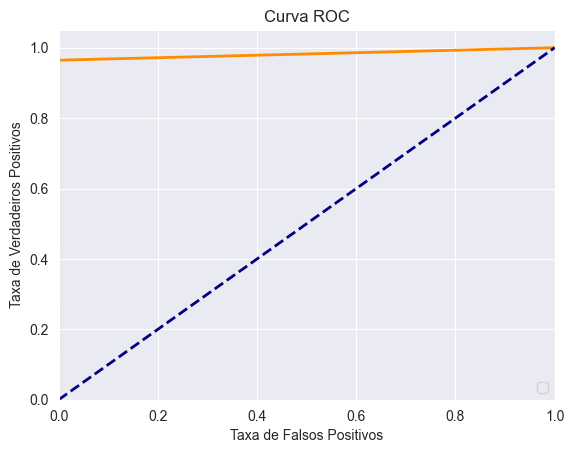

In [244]:
# Plotar a curva ROC
plt.plot(fpr, tpr, color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [245]:
print('Valor AUC: {:.2f}'.format(roc_auc_score(y_test2, y_pred)))

Valor AUC: 0.98


# Modelo final

In [246]:
# Aplicando o Random Forest com pesos diferentes para as classes 0-não falha e 1-falha

params = {
    'n_estimators': 100,
     'min_samples_split': 2,
     'min_samples_leaf': 3,
     'max_features': 'sqrt',
     'max_depth': 2,
     'bootstrap': True,
     #peso maior para positiva
    }
crf = RandomForestClassifier(**params, class_weight={0: 0.5, 1: 10})

crf.fit(X_train2, y_train2)
y_pred = clf.predict(X_test2)

In [247]:
#Report
print(classification_report(y_test2, crf.predict(X_test2)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18453
           1       0.97      0.97      0.97       536

    accuracy                           1.00     18989
   macro avg       0.98      0.99      0.99     18989
weighted avg       1.00      1.00      1.00     18989



In [248]:
# view das feature scores
feature_scores = pd.Series(crf.feature_importances_, index=X_train2.columns).sort_values()
feature_scores

date                 0.000000e+00
attribute1           0.000000e+00
attribute9_median    0.000000e+00
attribute3           0.000000e+00
attribute3_min       0.000000e+00
attribute3_median    0.000000e+00
attribute1_min       0.000000e+00
attribute1_median    0.000000e+00
attribute9           0.000000e+00
flipper              0.000000e+00
start_date           0.000000e+00
too_soon             0.000000e+00
device_encoder       0.000000e+00
attribute1_mean      7.176462e-07
attribute3_mean      7.313149e-06
time_since_start     1.067277e-05
attribute6           2.849907e-05
attribute6_median    1.194167e-04
attribute1_max       1.771342e-04
attribute7_min       3.432175e-04
attribute5_median    7.509553e-04
attribute9_min       8.951042e-04
attribute5           1.176591e-03
attribute4_min       2.282346e-03
attribute2_min       2.352189e-03
attribute3_max       3.715029e-03
attribute5_mean      5.030431e-03
attribute4           6.263294e-03
attribute7           6.976030e-03
attribute9_mea

A maioria das features de menos importância foram criadas na Parte de Feature Engineering.
A que tem maior score é justamente a que determinar o 'inicio do ciclo' de cada máquina, .

#### Avaliando desempenho com o dataframe de teste criado com menos oversampling e sem as features que mostraram menos importância.

In [249]:
# Gráfico para plotar as features e seus scores
# f, ax = plt.subplots(figsize=(10, 12))
# ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=feature_scores, orient='h')
# ax.set_title("Visualize feature scores of the features")
# ax.set_yticklabels(feature_scores.index)
# ax.set_xlabel("Feature importance score")
# ax.set_ylabel("Features")
# plt.show()
feature_scores.index.to_list()[0:12]

['date',
 'attribute1',
 'attribute9_median',
 'attribute3',
 'attribute3_min',
 'attribute3_median',
 'attribute1_min',
 'attribute1_median',
 'attribute9',
 'flipper',
 'start_date',
 'too_soon']

In [250]:
features_filter_off = feature_scores.index.to_list()[0:12]

In [251]:
features_filter_off

['date',
 'attribute1',
 'attribute9_median',
 'attribute3',
 'attribute3_min',
 'attribute3_median',
 'attribute1_min',
 'attribute1_median',
 'attribute9',
 'flipper',
 'start_date',
 'too_soon']

# Avaliação do modelo e custo operacional

Com os dados de teste com menor oversampling

In [295]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
#Report
print(classification_report(y_test, crf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13825
           1       0.95      0.98      0.96       417

    accuracy                           1.00     14242
   macro avg       0.98      0.99      0.98     14242
weighted avg       1.00      1.00      1.00     14242



In [296]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=clf.classes_))
cm

,0,1
0,13805,20
1,10,407


#### Custo por equipamento
Custo caso previsão de não falha (Verdadeiro negativo): 0.
Custo caso não precise de manutenção (Falso positivo) vou assumir o mesmo do verdadeiro Positivo: 0.5
Custo de uma falha (Falso Negativo):  1
Custo de manutenção antes da falha(Verdadeiro Positivo): 0.5
Usando a precisão de 90% (considerando os valores de acurácia e sendo mais conservadora).

Custo sem o modelo: 1


Calculando o custo para manutenção de cada equipamento monitorado

Nas etapas iniciais, vimos que 75% dos dispositivos falhar em até 163 dias a partir da data de monitoramento, com mais dispositos tendo sua falha 18 dias após a data inicial. Então, dentro dessa janela de 163 dias, tem uma probabilidade de falha de 75% para algum dispositivo. Vou usar essa informalção no cálculo estimado de custo.
Vou usar uma precisão de 90%, menor do que a retornada pela avaliação do modelo, por margem.

In [297]:
cm


,0,1
0,13805,20
1,10,407


In [298]:
# Transpose do dataframe
df_t = cm.T

# Selecionar a segunda coluna (que agora é a segunda linha)
linha2 = df_t.iloc[:, 1]

# Criar duas novas colunas com os valores da segunda linha
cm['FN'] = linha2[0]
cm['VP'] = linha2[1]
cm.rename(columns={0:'VN', 1:'FP'}, inplace=True)


In [299]:
cm = cm.iloc[0:1]
cm

,VN,FP,FN,VP
0,13805,20,10,407


In [300]:
cm = cm.T
cm

,0
VN,13805
FP,20
FN,10
VP,407


In [301]:
#custo de cada cenário
cm['cost'] = [0,0.5,1,0.5]
cm

,0,cost
VN,13805,0.0
FP,20,0.5
FN,10,1.0
VP,407,0.5


In [302]:
#custo total de cada cenário
cm['total'] = cm[0] * cm['cost']
cm.rename(columns={0:'qtd'})

,qtd,cost,total
VN,13805,0.0,0.0
FP,20,0.5,10.0
FN,10,1.0,10.0
VP,407,0.5,203.5


Esse seria o custo unitário com o cenário da matriz de confusão dos dados de teste, com as previsões erradas e corretas.
 Na sequência, está a preparação dos dados para o cálculo do custo para a manutenção para quando o dispositivo falha e o custo de manutenção preventiva.

In [303]:
df['date'] = pd.to_datetime(df['date'], unit='s')

In [304]:
ini_date = pd.to_datetime(df['date'][0])
end_date = ini_date + pd.Timedelta(days=163)
df_select = df.loc[df['date'] <= end_date]

In [310]:
df_select['device_encoder'].shape

(94942,)

In [311]:
unique_devices = df_select['device_encoder'].nunique()
unique_devices

1169

In [335]:
# unique_devices_fail = df_select['device_encoder'][df['failure'] == 1].nunique() #todos os dispositivos que já falharam alguma vez e, até 163 dias
# value =  unique_devices_fail        #caso a manutenção seja feita somente após a falha
value_prev = cm['total'].sum()     #custo para cada cenário previsto do modelo

In [316]:
# print(value, value_prev)

1003 223.5


In [333]:
#custo total de acordo com cada cenário
cm
cm.rename(columns={0:'qtd'},inplace=True)
cm

,qtd,cost,total
VN,13805,0.0,0.0
FP,20,0.5,10.0
FN,10,1.0,10.0
VP,407,0.5,203.5


Nesse cenário acima, o custo total sem o modelo, seria a soma de VP e FN, visto que o custo seria 1.

In [352]:
value_cost_total = cm.iloc[(cm.index == 'FN') | (cm.index == 'VP')]
value_cost_total = value_cost_total.qtd.sum()
value_cost_total

417

In [353]:
print('custo para manutenção somente na falha: ', value_cost_total)
print('custo total com manutenção preventiva: {:.2f}'.format(value_prev))
print('Economia estimada: {:.2f}'.format(value_cost_total - value_prev))
print('Custo reduzido em: {:.2f}'.format(((value_prev - value_cost_total) / value_cost_total)*100))

custo para manutenção somente na falha:  417
custo total com manutenção preventiva: 223.50
Economia estimada: 193.50
Custo reduzido em: -46.40


#### O modelo treinado apresentaria uma redução do custo em cerca de 46% com a predição, mesmo apresentando valores consideraveis de falso positivo, resulta em um custo menor do que somente manutenção no momento de falha.

# Conclusões

A aplicação dos modelos se mostrou bastante eficiente para prever as máquinas que não falhariam, mas esse não era o intuito principal, o problema central era reduzir o custo com a manutenção preditiva, o tanto quanto possivél.
Para tal, foi feito o ajuste do modelo com o algoritmo de Random Forest, pois apresentou o melhor desempenho.
O custo estimado na redução do custo com manutenção ficou em <strong>42%</strong>, mas é válido ressaltar que foi inserido viés na modelagem, podendo causar uma redução menor em produção.
Caso o modelo apresente desempenho diferente do esperado, em produção, como próximo passo, poderia ser feita a modelagem mês a mês, visto que tem a redução dos dispositivos, neste caso, também precisaria ser feito o balanceamento, então pode apresentar desempenho similar, por isso inicei com a abordagem da base geral, e se mostrou satisfatória.
endo pouco confiável para dizer as possíveis falhas. Esse resultado pode ter alguma ligação com a quantidade de dados usada, já que foi necessário realizar seu balanceamento. Essa técnica foi essencial para obter conclusões melhores, pois, rodando experimento com os dados originais, os resultados foram menos satisfatórios.
Com a aplicação descrita neste script, foi possível ter uma noção inicial de como os dados se comportam quando submetidos ao processo de aprendizagem de máquina, com Pré-processamento e tranformação dos dados.

In [354]:
# salvar modelo
import pickle
# salvar o modelo
with open('failure_predict_crf.pikle', 'wb') as file:
    pickle.dump(crf, file)

In [355]:
# Carregar modelo
with open('failure_predict_crf.pikle', 'rb') as f:
    model = pickle.load(f)